In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [16]:
df = pd.read_csv(f'./data/combined.csv')
df_gesamt = df[df['Age'] == 'gesamt']
df_gesamt['Date'] = pd.to_datetime(df_gesamt['Year'].astype(str) + df_gesamt['Week'].astype(str).str.zfill(2) + '1', format='%Y%W%w')
df_gesamt= df_gesamt.drop(columns=['Year','Week','Age'])
df_gesamt.set_index(['Date'],inplace = True)
df_gesamt = df_gesamt.fillna(0)
#df_gesamt = df_gesamt[['Value_Covid']]

df_policy = pd.read_csv(f'./data/Policy_Weekly_Extended.csv')
df_policy['Date'] = pd.to_datetime(df_policy['Year'].astype(str) + df_policy['Week'].astype(str).str.zfill(2) + '1', format='%Y%W%w')
df_policy = df_policy.drop(columns=['Year','Week'])
df_policy.set_index(['Date'],inplace = True)
df_policy = df_policy.fillna(0)
df_policy = df_policy[['C1E_School closing','C2E_Workplace closing','C3E_Cancel public events','C4E_Restrictions on gatherings','C5E_Close public transport','C6E_Stay at home requirements','C7E_Restrictions on internal movement']]*1000

df_gesamt = df_policy.merge(df_gesamt, on='Date', how='left')
split = int(0.4*len(df_gesamt))
#train, test = timeseries[:split], timeseries[split:]
df_gesamt = df_gesamt[:split]
df_diff = df_gesamt.diff().dropna()

model = VAR(df_diff)
results = model.fit(maxlags=15, ic='aic')

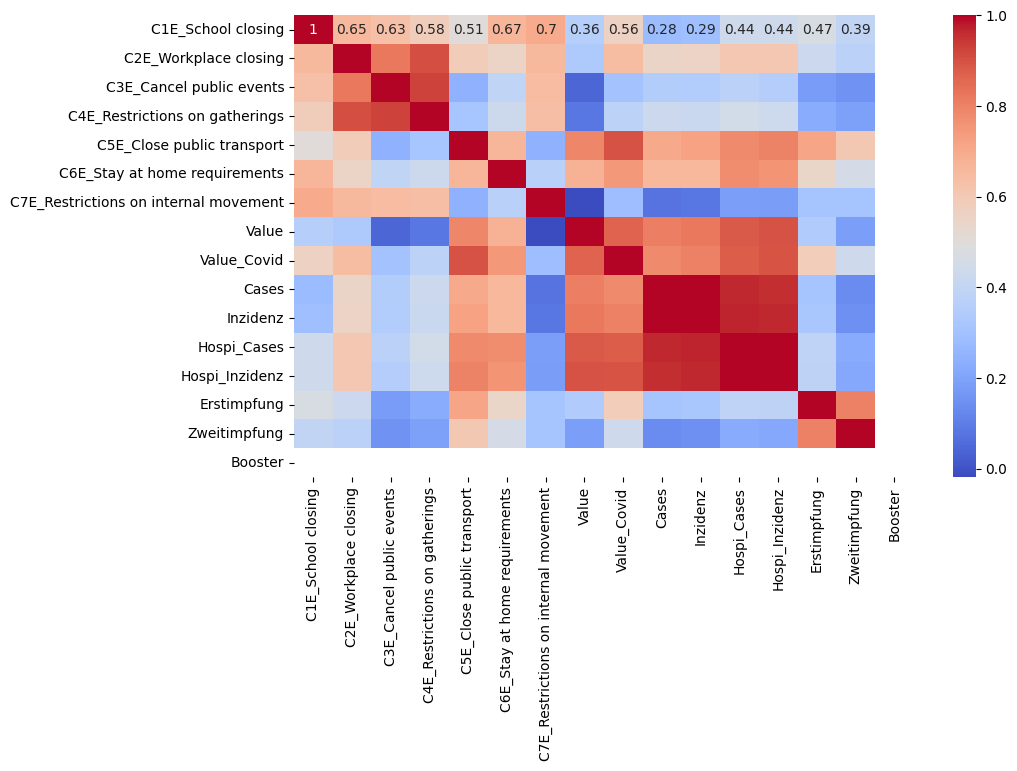

In [17]:
corr_matrix = df_gesamt.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [56]:
lag_order = results.k_ar
forecast_steps = 10
forecast = results.forecast(df_diff.values[-lag_order:], steps = forecast_steps)
forecast_df = pd.DataFrame(forecast, index = pd.date_range(start=df_gesamt.index[-1], periods=forecast_steps+1, freq='D')[1:],columns = df_gesamt.columns)
for column in df_gesamt.columns:
    forecast_df[column] = df_gesamt[column].iloc[-1] + forecast_df[column].cumsum()

combined_df = pd.concat([df_gesamt,forecast_df])


fig = go.Figure()
for column in df_gesamt.columns:
    fig.add_trace(go.Scatter(
        x=combined_df.index, 
        y=combined_df[column], 
        mode='lines', 
        name=f'Observed {column}'
    ))
    fig.add_trace(go.Scatter(
        x=forecast_df.index, 
        y=forecast_df[column], 
        mode='lines', 
        name= f'Forecast {column}'
    ))


fig.update_layout(
    title='VAR(Vector Autoregression)',
    xaxis_title='Year',
    yaxis_title='Metric'
)
fig.show()

In [ ]:
timeseries = df_gesamt['Value_Covid']
split = int(0.9*len(timeseries))
train, test = timeseries[:split], timeseries[split:]
model = pm.auto_arima(train, 
                      start_p=0, start_q=0,
                      test='adf',       # Use adftest to find optimal 'd'
                      max_p=5, max_q=5, max_d=3, # Maximum p and q
                      m=2,             # Seasonality
                      start_P=0, start_Q=0,
                      max_P=10, max_Q=10, max_D=3, # Maximum p and q
                      seasonal=True,    # Seasonal ARIMA
                      d=1,           # Let model determine 'd'
                      D=1,              # Seasonal difference
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise search to find the best model

# Summarize the model
print(model.summary())

# Frecast future values
forecast = model.predict(n_periods=len(test))
forecast.index = test.index
print(forecast)
plt.figure(figsize=(10, 5))
plt.plot(timeseries.index, timeseries, label='Observed')
plt.plot(forecast.index, forecast, label='Fitted', color='red')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()
#print(f"MSE: {mse(monthly_temp['temp'][:split],monthly_temp['forecast'][:split]):.2f}")
print(type(model))
results = model

forecast_steps = 10
forecast = results.get_forecast(steps=forecast_steps)
print(forecast.predicted_mean.reset_index(drop=True))
forecast_index = np.arange(df.index[-1] + 1, df.index[-1] + 1 + forecast_steps)
print(forecast_index)
forecast_df = pd.DataFrame({'Year':forecast_index,'Forecast': forecast.predicted_mean.reset_index(drop=True)})
forecast_df = forecast_df.set_index('Year')
plt.figure(figsize=(10, 5))
plt.plot(df.index, df, label='Observed')
plt.plot(df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(df.index,forecast.conf_int().iloc[:, 0],forecast.conf_int().iloc[:, 1],color='pink', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
forecast = 52
pred_summary = results.get_prediction(0, len(timeseries.index)+forecast).summary_frame()
display(pred_summary.index)
plot_ci = False
pre_test = 200
display(timeseries)
timeseries_cut = timeseries[split-pre_test:]
display(timeseries_cut)
pred_summary_cut = pred_summary[split-pre_test:]
print(rmse(timeseries_cut,pred_summary_cut[:-1-forecast]['mean']))
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=timeseries_cut.index, 
    y=timeseries_cut, 
    mode='lines', 
    name='Ground Truth'
))
fig.add_trace(go.Scatter(
    x=timeseries_cut.index, 
    y=pred_summary_cut['mean'], 
    mode='lines', 
    name='Prediction'
))
if plot_ci:
    fig.add_trace(go.Scatter(
        x=timeseries_cut.index, 
        y=pred_summary_cut['mean_ci_lower'], 
        fill=None,
        mode='lines',
        line=dict(color='lightgrey'),
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=timeseries_cut.index, 
        y=pred_summary_cut['mean_ci_upper'], 
        fill='tonexty',  # fill area between trace_ci_lower and trace_ci_upper
        mode='lines',
        line=dict(color='lightgrey'),
        showlegend=False
    ))
fig.add_shape(
    dict(
        type="line",
        x0=test.index[0],
        y0=timeseries_cut.min(),  # Set y0 to a value within the plot's range
        x1=test.index[0],
        y1=timeseries_cut.max(),  # Set y1 to a value within the plot's range
        line=dict(
            color="Black",
            width=2,
            dash="dashdot",
        )
    )
)

fig.update_layout(
    title='Sarima on weekly',
    xaxis_title='Year',
    yaxis_title='Death Rate'
)
fig.show()